In [239]:
import h5py
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as func 
from torch.nn.functional import normalize
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [240]:
piplus = h5py.File('/fast_scratch_1/QVAE/data/calo_scaled/piplus.hdf5', 'r')
eplus = h5py.File('/fast_scratch_1/QVAE/data/calo_scaled/eplus.hdf5', 'r')

In [241]:
pp_layer_0 = torch.tensor(np.array(piplus['layer_0']))
pp_layer_1 = torch.tensor(np.array(piplus['layer_1']))
pp_layer_2 = torch.tensor(np.array(piplus['layer_2']))
pp_flatten_0 = torch.flatten(pp_layer_0, start_dim=1)
pp_flatten_1 = torch.flatten(pp_layer_1, start_dim=1)
pp_flatten_2 = torch.flatten(pp_layer_2, start_dim=1)
pp = torch.cat((pp_flatten_0,pp_flatten_1,pp_flatten_2), dim=1)

In [242]:
ep_layer_0 = torch.tensor(np.array(eplus['layer_0']))
ep_layer_1 = torch.tensor(np.array(eplus['layer_1']))
ep_layer_2 = torch.tensor(np.array(eplus['layer_2']))
ep_flatten_0 = torch.flatten(ep_layer_0, start_dim=1)
ep_flatten_1 = torch.flatten(ep_layer_1, start_dim=1)
ep_flatten_2 = torch.flatten(ep_layer_2, start_dim=1)
ep = torch.cat((ep_flatten_0,ep_flatten_1,ep_flatten_2), dim=1)

In [222]:
# triumf_ml1_dir = '/home/s4hoque/DwaveSampInteg'
# # load data and process data
# # piplus path
# d1 = triumf_ml1_dir+'/CaloQVAE/outputs/2022-12-01/22-29-17/synthetic_images_piplus.pt'
# d2 = triumf_ml1_dir+'/CaloQVAE/outputs/2022-11-30/22-26-46/synthetic_images_eplus.pt'
# d1_data = torch.load(d1)
# d2_data = torch.load(d2)
# d1_tensor = torch.cat(d1_data) # not normalized
# d2_tensor = torch.cat(d2_data) # not normalized
# d1_tensor.size()
# pp_flatten_1 = d1_tensor[:, 288:144+288]
# ep_flatten_1 = d2_tensor[:, 288:144+288]

In [243]:
# define labels
pp_labels = torch.ones(pp_flatten_1.size(0)) # ones
ep_labels = torch.zeros(ep_flatten_1.size(0)) # zeros
# concat data and labels
#inputs = torch.cat((pp, ep),dim=0) # pred
inputs = torch.cat((pp_flatten_1, ep_flatten_1), dim=0) # flattening dimension 1
#inputs = normalize(inputs, dim=1)
labels = torch.cat((pp_labels, ep_labels), dim=0)
dataset = TensorDataset(inputs, labels)
data_loader = DataLoader(dataset, shuffle=True, batch_size=inputs.size(0))
inputs = next(iter(data_loader))[0].float()
targets = next(iter(data_loader))[1]

In [244]:
class Net(nn.Module):
    """
    This class builds the neural network structure with 3 layers.
        Layer 1: num_features number of units
        layer 2: num_hiddden_units=100 hidden units seem to work well
        layer 3: num_classes=5 number of output classes
    """
    def __init__(self, num_features, num_hiddden_units, num_classes):
        super(Net, self).__init__() 
        self.fc1= nn.Linear(num_features, num_hiddden_units)
        self.fc2= nn.Linear(num_hiddden_units, num_classes) 
    
    def forward(self, x):
        h1 = torch.relu(self.fc1(x))
        h1 = func.dropout(h1,p=0.25)
        y = torch.sigmoid(self.fc2(h1))
        return y

    def reset(self):
        self.fc1.reset_parameters()
        self.fc2.reset_parameters()

In [245]:
model = Net(num_features=144, num_hiddden_units=40, num_classes=1)
#outp = model.forward(inputs)

In [246]:
inputs.size()

torch.Size([200000, 144])

In [247]:
num_epochs=50000
display_epochs=100
optimizer = optim.Adam(model.parameters(), lr=0.20)
loss = torch.nn.L1Loss(reduction= 'mean')
obj_vals= []  
for epoch in range(num_epochs):   
    model_output = model.forward(inputs).reshape(-1)
    pred = (model_output>0.5).float()
    diff_tensor =  pred - targets 
    diff_tensor = torch.abs(diff_tensor)
    accuracy = 1-torch.sum(diff_tensor)/pred.size(0)
    obj_val = loss(model_output, targets)
    optimizer.zero_grad() 
    obj_val.backward() 
    optimizer.step() 
    obj_vals.append(obj_val.item())
    if (epoch+1) % display_epochs == 0:
        print ('Epoch [{}/{}]\tTrain Loss :{:.4f}\t accuracy :{:.4f}%'.format(epoch+1, num_epochs, obj_val.item(), accuracy*100))
print("\nTraining Completed")

Epoch [100/50000]	Train Loss :0.4934	 accuracy :50.6600%
Epoch [200/50000]	Train Loss :0.4900	 accuracy :51.0025%
Epoch [300/50000]	Train Loss :0.4929	 accuracy :50.7240%
Epoch [400/50000]	Train Loss :0.4918	 accuracy :50.8430%
Epoch [500/50000]	Train Loss :0.4937	 accuracy :50.6415%
Epoch [600/50000]	Train Loss :0.4913	 accuracy :50.9065%
Epoch [700/50000]	Train Loss :0.4915	 accuracy :50.8670%
Epoch [800/50000]	Train Loss :0.4890	 accuracy :51.1335%
Epoch [900/50000]	Train Loss :0.4878	 accuracy :51.2390%
Epoch [1000/50000]	Train Loss :0.4889	 accuracy :51.1200%
Epoch [1100/50000]	Train Loss :0.4863	 accuracy :51.3900%
Epoch [1200/50000]	Train Loss :0.4875	 accuracy :51.2780%
Epoch [1300/50000]	Train Loss :0.4912	 accuracy :50.8790%
Epoch [1400/50000]	Train Loss :0.4902	 accuracy :51.0020%
Epoch [1500/50000]	Train Loss :0.4900	 accuracy :51.0260%
Epoch [1600/50000]	Train Loss :0.4914	 accuracy :50.8650%
Epoch [1700/50000]	Train Loss :0.4925	 accuracy :50.7730%
Epoch [1800/50000]	Trai

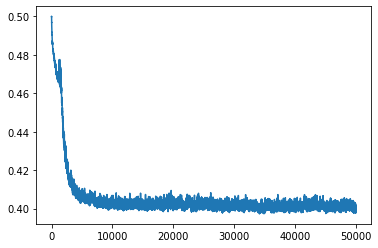

In [210]:
plt.plot(range(num_epochs), obj_vals)

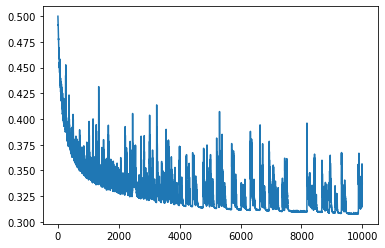

In [102]:
plt.plot(range(num_epochs), obj_vals)

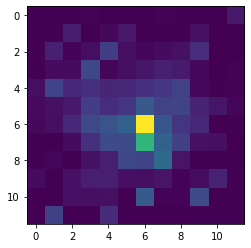

In [279]:
plt.imshow(pp_layer_1[7])

In [136]:
pp_layer_0.size()

torch.Size([100000, 3, 96])

In [ ]:
num = 5262
plt.imshow(ep_layer_2[num])

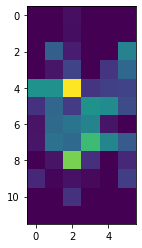

In [277]:
plt.imshow(pp_layer_2[num])

In [278]:
ep_layer_2[num]

tensor([[0.0000, 0.0000, 0.0000, 0.6370, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.7108, 0.0000],
        [0.0218, 0.0000, 0.1645, 0.0754, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0515, 0.0000, 0.0000],
        [0.0000, 1.7281, 0.6692, 0.0893, 0.0000, 0.0000],
        [0.0000, 1.6937, 0.0377, 0.1882, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0794, 0.9023, 0.1749, 0.0000],
        [0.0000, 0.2470, 0.1776, 0.5519, 0.3153, 0.0000],
        [0.0000, 0.5561, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.2212, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]], dtype=torch.float64)